In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from lecilab_behavior_analysis.utils import load_example_data
%load_ext autoreload
%autoreload 2


In [2]:
mouse = "mouse1"
df = load_example_data(mouse)

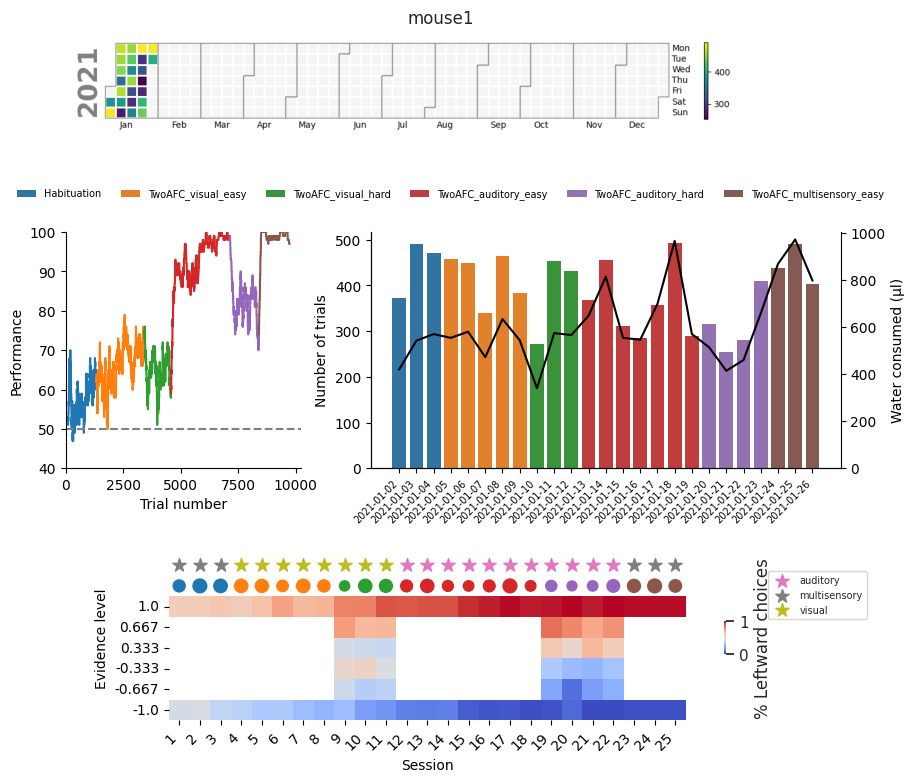

In [3]:
from lecilab_behavior_analysis.figure_maker import subject_progress_figure
fig = subject_progress_figure(df, mouse, perf_window=100)


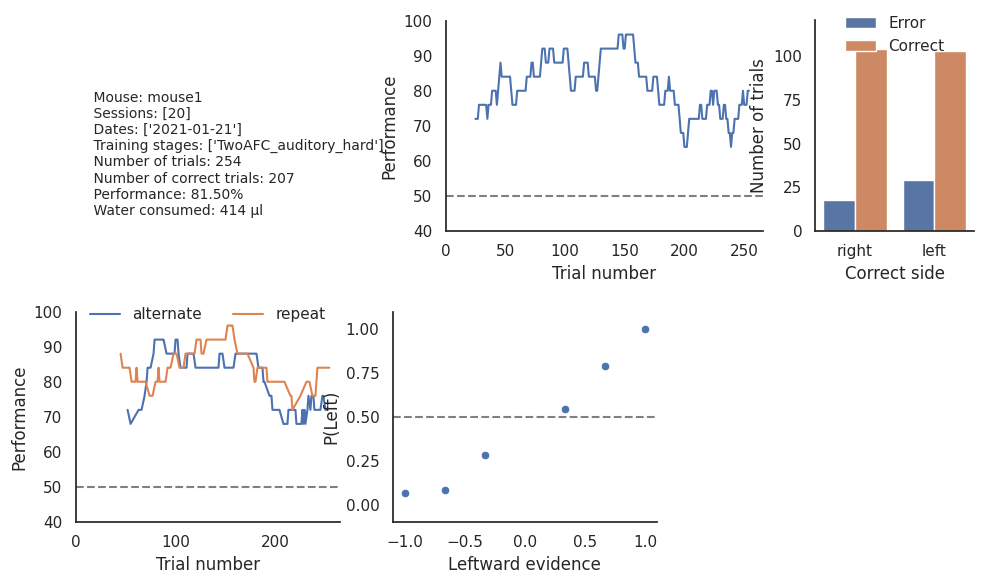

In [4]:
from lecilab_behavior_analysis.figure_maker import session_summary_figure
# select the session you want to plot
session = 20
sdf = df[df["session"] == session]
fig = session_summary_figure(sdf, mouse, perf_window=25)

<Axes: xlabel='Trial', ylabel='Time Between Trials (ms)'>

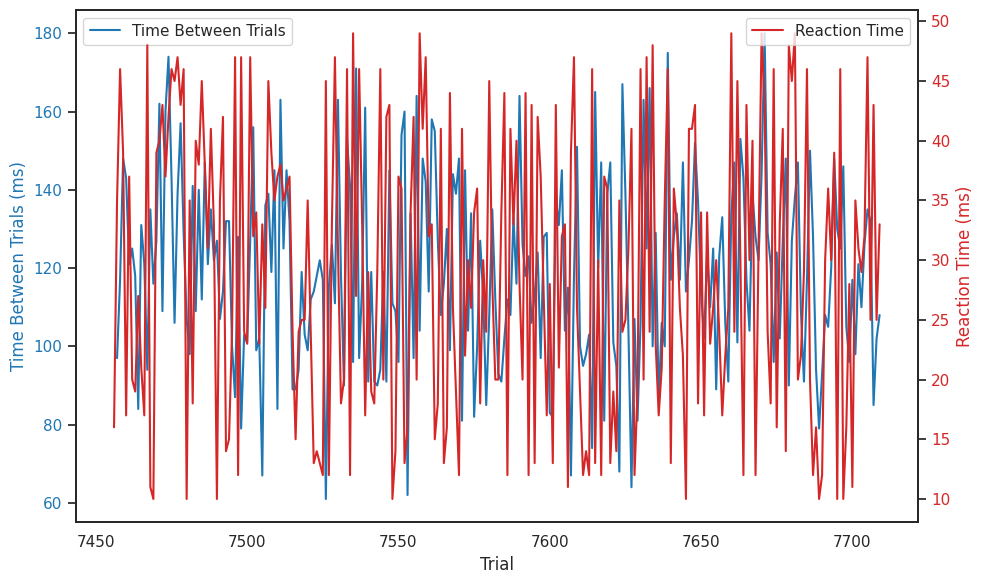

In [7]:
from lecilab_behavior_analysis.figure_maker import plot_time_between_trials_and_reaction_time
plot_time_between_trials_and_reaction_time(sdf)
# TODO Eloi: add the time between trials and reaction time to the session summary figure